In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

from torchsummary import summary

In [2]:
IMAGE_SIZE = 224
KERNEL = 3
STRIDE = 1
MAXPOOLING_STRIDE = 2
BATCH_SIZE = 256
MOMENTUM = 0.9
WEIGHT_DECAY = 5E-4
DROPOUT = 0.5
LEARNING_RATE = 1E-2
BIAS = 0
INITIALIZED_MEAN, STD = 0, 0.01
EPOCHS = 100

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
traindata = datasets.STL10(root = './datasetfolder', split = 'train', download = True, transform = transforms.ToTensor())
testdata = datasets.STL10(root = './datasetfolder', split = 'test', download = True, transform = transforms.ToTensor()) 

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./datasetfolder/stl10_binary.tar.gz to ./datasetfolder
Files already downloaded and verified


In [5]:
imgs, label = traindata[1]
print(imgs.shape)
print(len(traindata))
print(len(testdata))

torch.Size([3, 96, 96])
5000
8000


In [6]:
meanRGB = [np.mean(img.numpy(), axis = (1, 2)) for img, _ in traindata]
stdRGB = [np.std(img.numpy(), axis = (1, 2)) for img, _ in traindata]
#meanRGB[0] = set of the mean of R
#meanRGB[1] = set of the mean of G
#meanRGB[2] = mean of the mean of B

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.std([s[0] for s in stdRGB])
stdG = np.std([s[1] for s in stdRGB])
stdB = np.std([s[2] for s in stdRGB])

In [7]:
print('Mean of the RGB : ', meanR, meanG, meanB)
print("Std of the RGB", stdR, stdG, stdB)

Mean of the RGB :  0.4467106 0.43980986 0.40664646
Std of the RGB 0.061958 0.06189533 0.068922155


In [8]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.Normalize((meanR, meanG, meanB), (stdR, stdG, stdB))
])

In [9]:
traindata.transform  = transforms
testdata.transform = transforms

In [10]:
trainloader = DataLoader(dataset = traindata, batch_size = BATCH_SIZE, shuffle = True)
testloader = DataLoader(dataset = testdata, batch_size = BATCH_SIZE)

In [11]:
img, label = next(iter(trainloader))
print(img.shape)
print(label.shape)
print(len(trainloader))

torch.Size([256, 3, 224, 224])
torch.Size([256])
20


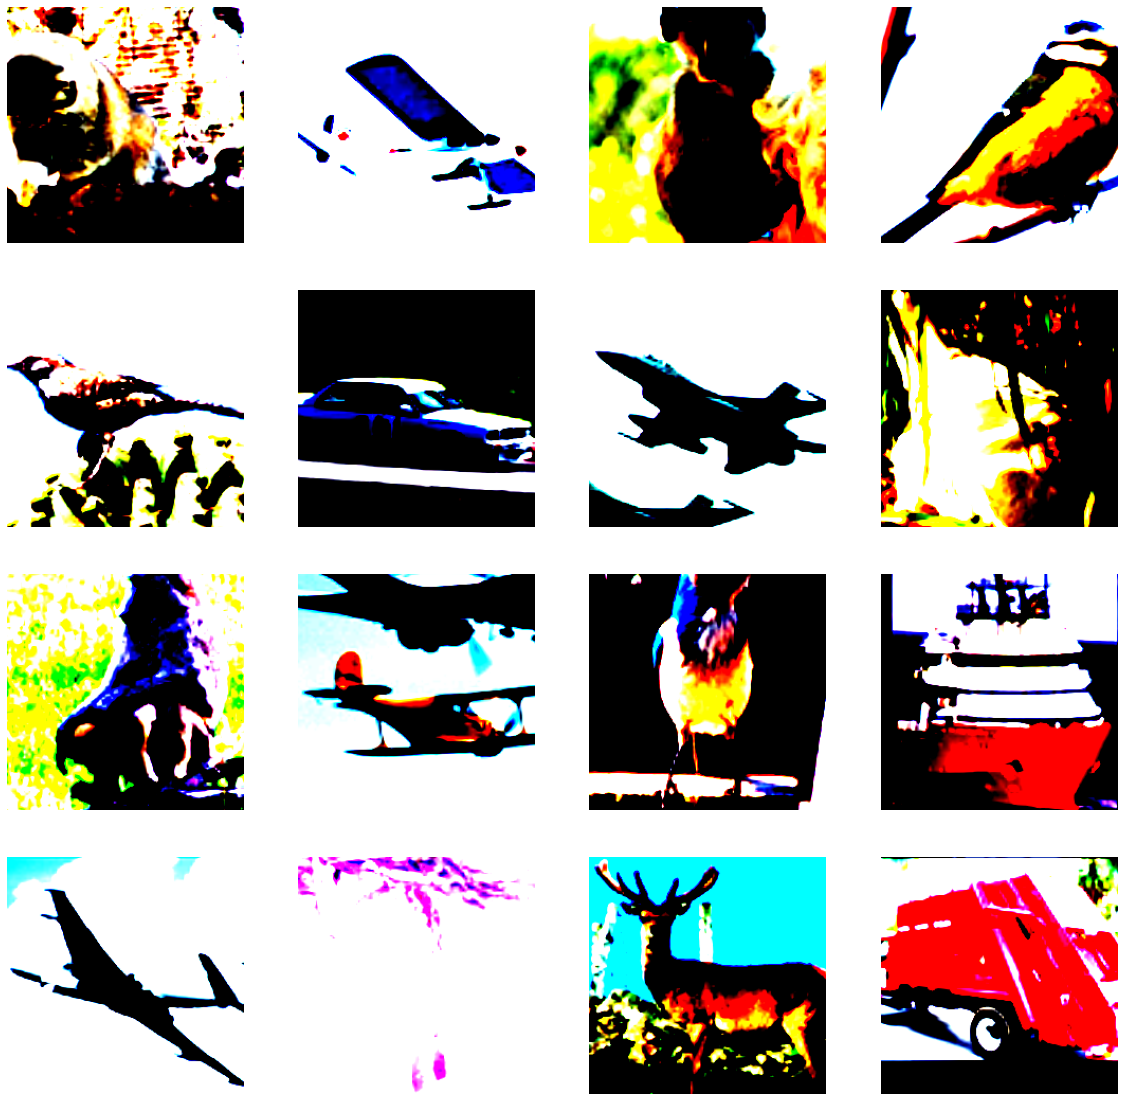

In [12]:
plt.figure(figsize = (20, 20))
for i in range(1, 16 + 1):
  plt.subplot(4, 4, i)
  plt.imshow(np.clip(img[i], 0, 1).permute(1, 2, 0))
  plt.axis('off')

In [13]:
layer_config = {
    'D' :[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #VGG16
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] # VGG19 
}

In [14]:
def make_layers(config):
  layers = []
  in_channels = 3

  for value in config:
    if value == 'M':
      layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
    else:
      layers.append(nn.Conv2d(in_channels = in_channels, out_channels = value, kernel_size = 3, stride = 1, padding = 1))
      layers.append(nn.ReLU())
      in_channels = value
  return nn.Sequential(*layers)

In [40]:
class VGG(nn.Module):
  def __init__(self, config, num_classes = 10):
    super().__init__()

    self.feature_extractor = make_layers(config)

    self.classifier = nn.Sequential(
        nn.Linear(7*7*512, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, num_classes)
    )
  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

In [41]:
def VGG16_(config):
  return VGG(layer_config['D'])

def VGG19_(config):
  return VGG(layer_config['E'])

In [61]:
class VGGEnsemble(nn.Module):
  def __init__(self, modelA, modelB, num_classes):
    super().__init__()

    self.modelA = modelA
    self.modelB = modelB

  def forward(self, x):
    
    x1 = self.modelA(x)
    x2 = self.modelB(x)

    output = x1 + x2
    output = nn.Softmax(dim = 1)(output)
    return output

In [59]:
VGG16 = VGG16_(layer_config).to(device)
VGG19 = VGG19_(layer_config).to(device)

In [60]:
print(VGG16)
print(VGG19)

VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1

In [49]:
summary(VGG16, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [50]:
summary(VGG19, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [67]:
model = VGGEnsemble(VGG16, VGG19, 10).to(device)
model

VGGEnsemble(
  (modelA): VGG(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU()
      (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [71]:
def weight_initialization(m):
  if type(m) == nn.Conv2d:
    torch.nn.init.normal_(m.weight.data, INITIALIZED_MEAN, STD)
    print('init success')
  elif type(m) == nn.Linear:
    torch.nn.init.normal_(m.weight.data, INITIALIZED_MEAN, STD)
    print('init success')

In [72]:
model.apply(weight_initialization)

init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success
init success


VGGEnsemble(
  (modelA): VGG(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU()
      (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [75]:
optim = optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum = MOMENTUM, weight_decay = WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def accuracy_rate(pred, target):

  pred = pred.argmax(1)
  correct = pred.eq(target.view_as(pred)).sum().item()
  correct_rate = correct / target.shape[0]
  return correct_rate

In [1]:
def train(model, trainloader, optimizer, criterion, deivce):

  model.train()
  runninng_loss = 0.0
  running_acc = 0.0
  for imgs, labels in trainloader:
    optim.zero_grad()
    imgs, labels = imgs.to(device), labels.to(device)

    pred = model(imgs)

    train_loss = criterion(pred, labels)

    train_loss.backward()

    optim.step()

    accuracy += accuracy_rate(pred, labels).item()
    running_loss += train_loss.item()

  return running_loss, accuracy

In [2]:
def evaluate(model, testloader, criterion, device):

  model.eval()

  running_loss = 0.0
  running_acc = 0.0

  with torch.no_grad():

    for imgs, labels in testloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      
      test_loss = criterion(pred, labels)

      accuracy += accuracy_rate(pred, labels).item()
      running_loss += test_loss.item()
    return running_loss, accuracy,

In [ ]:
for epoch in range(EPOCHS):
  
  train_loss, train_acc = train(model, trainloader, optim, criterion, device)
  
  print('Epoch : ', epoch +1, 'Loss :', train_loss, 'Acc :', train_acc)